<a href="https://colab.research.google.com/github/WJ714/aec_correction/blob/master/tutorial_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. import necessary functions

In [1]:
!git clone https://github.com/WJ714/aec_correction.git

Cloning into 'aec_correction'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 65 (delta 26), reused 11 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 641.42 KiB | 11.25 MiB/s, done.
Resolving deltas: 100% (26/26), done.


then we 'cd to the work folder'

In [4]:
cd aec_correction

/content/aec_correction


In [5]:
from aec_correction.aec_function.aec import fcor_estimator, compute_r_p
import xarray as xr
import numpy as np

In [6]:
import seaborn as sns
sns.set(font_scale=1.3)

### 2. load example dataset

In [8]:
ds = xr.open_dataset('FR-Pue_2008_2013.nc')

### 3. Start estimating correction factor, **fcor_out**

In [9]:
LE, NETRAD, H, G, maskQC = ds['LE'], ds['NETRAD'],  ds['H'],ds['G'].fillna(0), ds['maskQC']

In [11]:
fcor_out = xr.DataArray(
                        np.nan,
                        coords={"time" : LE.time.values},
                        dims=("time",),
                        name="Fcor",
                        attrs={
                            'long_name': "Correction factor for energy balance closure",
                            "description":"Energy balance closure correction factor based on the Available Energy Correction algorithm.",
                            "units" : "unitless"
                        }
                    )

#### 3.1 We estimate the two types of correction factor then compute the geometric mean

In [12]:
_ds_fcor0 = fcor_estimator(LE, NETRAD, H, G, maskQC, ErrorIn='Error_In_LeH')
_ds_fcor1 = fcor_estimator(LE, NETRAD, H, G, maskQC, ErrorIn='Error_In_RnG')

fcor = np.sqrt(_ds_fcor0['FCor']*_ds_fcor1['FCor'])
fcor = np.fmax(fcor*0+1,fcor)

In [13]:
fcor.name = 'FCor'

#### 3.2 We then modity the correction factor at low Available energy conditons to be 1

In [14]:
_ds_fcor  = xr.merge([fcor, _ds_fcor1[['exog', 'endog']]])

In [15]:
df_sorted = (_ds_fcor.to_dataframe()).dropna(axis=0).sort_values(by='exog')
corr_coef = np.array([compute_r_p(df_sorted.iloc[:i]['exog'], df_sorted.iloc[:i]['endog']) for i in np.arange(len(df_sorted))])
df_sorted['r'] = corr_coef[:,0]
df_sorted['p'] = corr_coef[:,1]
ind_min = df_sorted['exog'][(df_sorted['r']>0) & (df_sorted['p']<0.1)][0]
thrd_ae = np.fmax(ind_min,0)

In [16]:
fcor = _ds_fcor['FCor'].where((_ds_fcor['exog']>thrd_ae)|(_ds_fcor['exog'].isnull()), 1)

In [17]:
fcor_out = fcor_out.fillna(fcor)

### 4. Diagnostic plots
#### 4.1 We can look at its temporal variations

In [18]:
import matplotlib.pyplot as plt

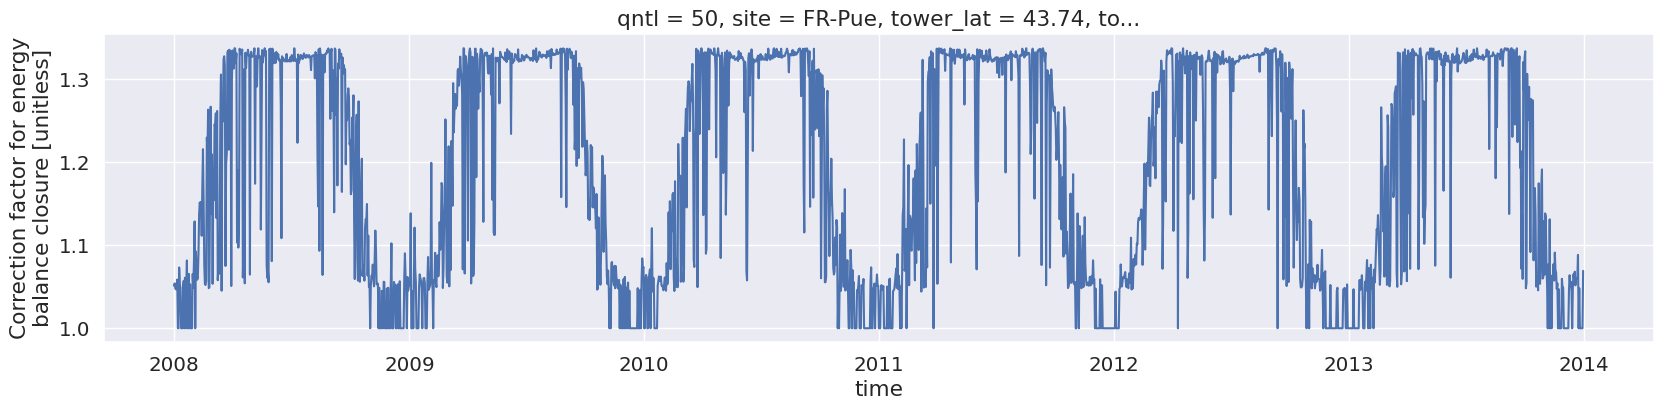

In [19]:
fcor_out.plot(figsize=(20,4))

#### 4.1 We can also look at Fcor vs. available energy (NETRAD-G)

#### Note: the Fcor in this tutorial might be different from the Fcor in the manuscript as here we only use two-year data to estimate the slope and fcor, while in the draft we used more years data (determined by the segment proposed in Jung et al., (2023))

Text(0, 0.5, 'Correction Factor')

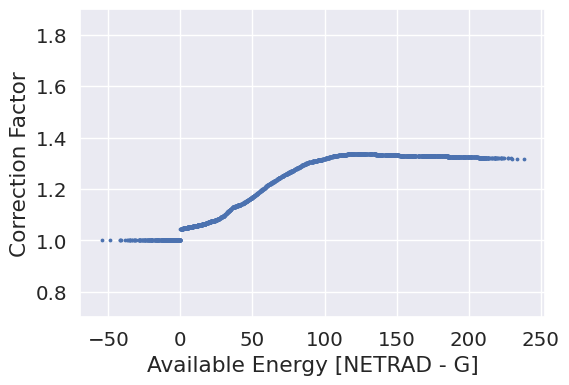

In [20]:
plt.figure(figsize=(6,4))
plt.scatter(NETRAD-G, fcor_out, s=3)
plt.ylim(0.7, 1.9)
plt.xlabel('Available Energy [NETRAD - G]')
plt.ylabel('Correction Factor')

#### 4.2 We can look at the energy balance closure before and after correction

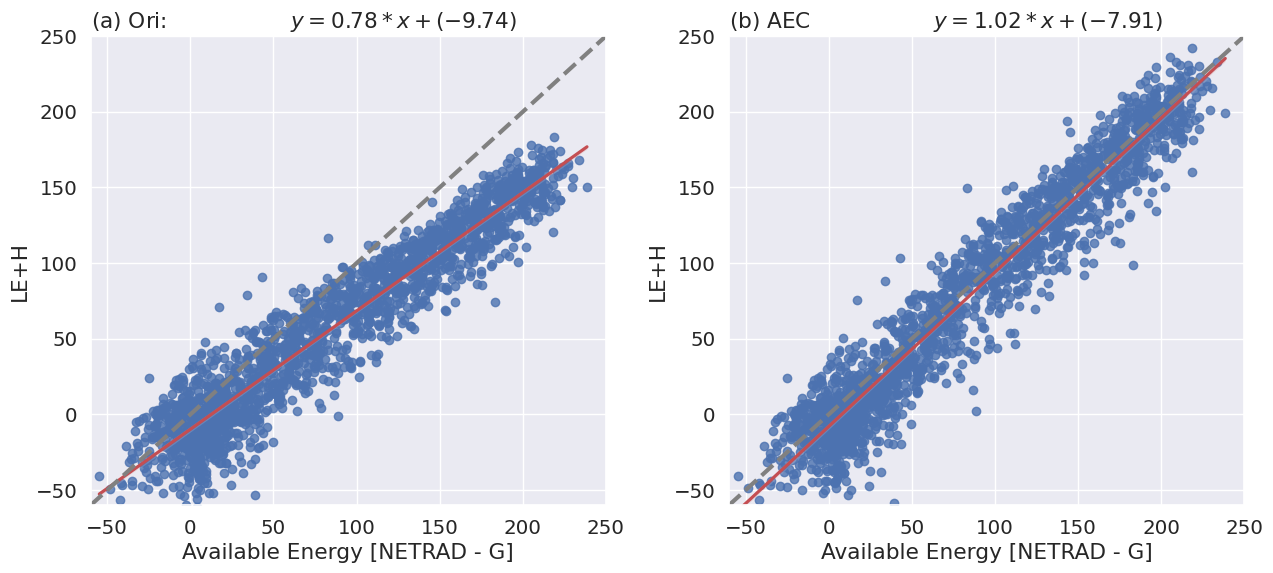

In [21]:
x = (NETRAD-G).where(maskQC&(fcor_out.notnull()))
y0 = (ds['LE_Ori']+H).where(maskQC&(fcor_out.notnull()))
y1 = (LE+H)*fcor_out
ys = [y0, y1]
titles = ['(a) Ori:', '(b) AEC']

fig, axes = plt.subplots(1,2, figsize=(13,6), sharex=True)
for i, ax in enumerate(axes):
    _m = x.notnull() & ys[i].notnull()
    slope, intercept = np.linalg.lstsq(np.vstack([x[_m], np.ones(len(x[_m]))]).T, ys[i][_m],rcond=None)[0]
    sns.regplot(x=x[_m].values,y=ys[i][_m].values,line_kws=dict(color="r"), ax = ax)
    ax.plot([-60,250],[-60,250], ls='--', color='grey', lw=3)
    ax.set_title(f"{titles[i]}\
                  $y = {np.round(slope.values,2)}*x+({np.round(intercept.values,2)})$",
                  loc='left')
    ax.set_ylabel('LE+H')
    ax.set_xlabel('Available Energy [NETRAD - G]')
    ax.set(xlim=(-60,250), ylim=(-60,250))
plt.tight_layout()